<a href="https://colab.research.google.com/github/shaadfazal/Hospital_readmission_prediction/blob/main/hospital_readmission_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The dataset used for the project is available at Kaggle https://www.kaggle.com/code/abbasjafary/hospital-readmission-prediction

In [1]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv("/content/diabetic_data.csv")

# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33243 entries, 0 to 33242
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   encounter_id              33243 non-null  int64  
 1   patient_nbr               33243 non-null  int64  
 2   race                      33243 non-null  object 
 3   gender                    33243 non-null  object 
 4   age                       33243 non-null  object 
 5   weight                    33243 non-null  object 
 6   admission_type_id         33243 non-null  int64  
 7   discharge_disposition_id  33243 non-null  int64  
 8   admission_source_id       33243 non-null  int64  
 9   time_in_hospital          33242 non-null  float64
 10  payer_code                33242 non-null  object 
 11  medical_specialty         33242 non-null  object 
 12  num_lab_procedures        33242 non-null  float64
 13  num_procedures            33242 non-null  float64
 14  num_me

In [2]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.5 MB/s eta 0:00:00


catboost model

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Load the complete dataset
df = pd.read_csv('/content/diabetic_data.csv')

# Step 2: Drop the columns we don't need
df.drop(columns=['encounter_id', 'patient_nbr'], inplace=True)

# Step 3: Get all remaining columns for encoding, except 'readmitted' (the target variable)
columns_to_check = df.columns.tolist()  # List all columns
columns_to_check.remove('readmitted')  # Remove target variable

# Dictionary to store label mappings for each column
label_mappings = {}

# Step 4: Apply Label Encoding and create mappings for all features
for column in columns_to_check:
    # Initialize label encoder
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

    # Store mapping for each column
    label_mappings[column] = dict(zip(le.classes_, le.transform(le.classes_)))

# Step 5: Encode `readmitted` to binary: 0 for 'NO', 1 for '<30' and '>30'
df['readmitted'] = df['readmitted'].apply(lambda x: 0 if x == 'NO' else 1)

# Save mappings for `readmitted` column
label_mappings['readmitted'] = {'NO': 0, '<30 or >30': 1}

# Step 6: Prepare the data for training
# Separate features and target variable
X = df.drop(columns=['readmitted'])
y = df['readmitted']

# Step 7: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Train the CatBoost model
model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, verbose=0)
model.fit(X_train, y_train)

# Step 9: Predictions and Evaluation
y_pred = model.predict(X_test)

# Calculate accuracy and print classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Output results
print("Encoded Dataset:")
print(df.head())
print("\nLabel Mappings:")
print(label_mappings)
print(f'\nAccuracy: {accuracy}')
print('Classification Report:')
print(report)


Encoded Dataset:
   race  gender  age  weight  admission_type_id  discharge_disposition_id  \
0     3       0    0       1                  5                        23   
1     3       0    1       1                  0                         0   
2     1       0    2       1                  0                         0   
3     3       1    3       1                  0                         0   
4     3       1    4       1                  0                         0   

   admission_source_id  time_in_hospital  payer_code  medical_specialty  ...  \
0                    0                 0           0                 38  ...   
1                    6                 2           0                  0  ...   
2                    6                 1           0                  0  ...   
3                    6                 1           0                  0  ...   
4                    6                 0           0                  0  ...   

   citoglipton  insulin  glyburide-metf

Encoded Dataset:
   race  gender  age  weight  admission_type_id  discharge_disposition_id  \
0     3       0    0       1                  5                        23   
1     3       0    1       1                  0                         0   
2     1       0    2       1                  0                         0   
3     3       1    3       1                  0                         0   
4     3       1    4       1                  0                         0   

   admission_source_id  time_in_hospital  payer_code  medical_specialty  ...  \
0                    0                 0           0                 38  ...   
1                    6                 2           0                  0  ...   
2                    6                 1           0                  0  ...   
3                    6                 1           0                  0  ...   
4                    6                 0           0                  0  ...   

   citoglipton  insulin  glyburide-metf

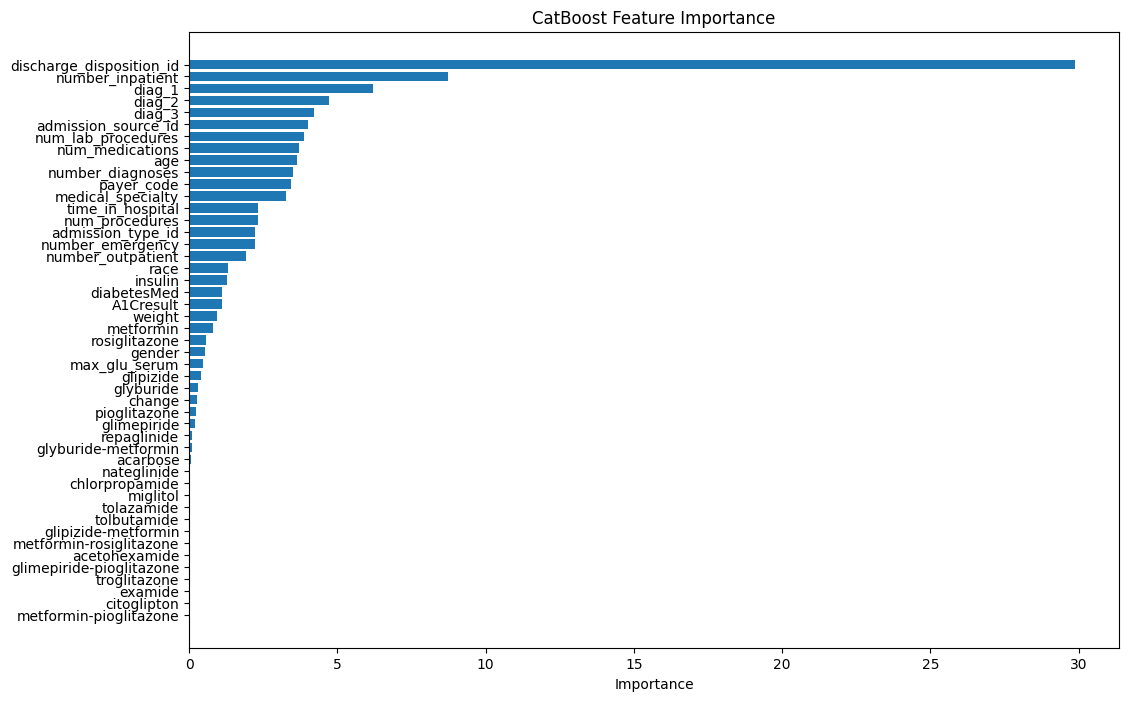

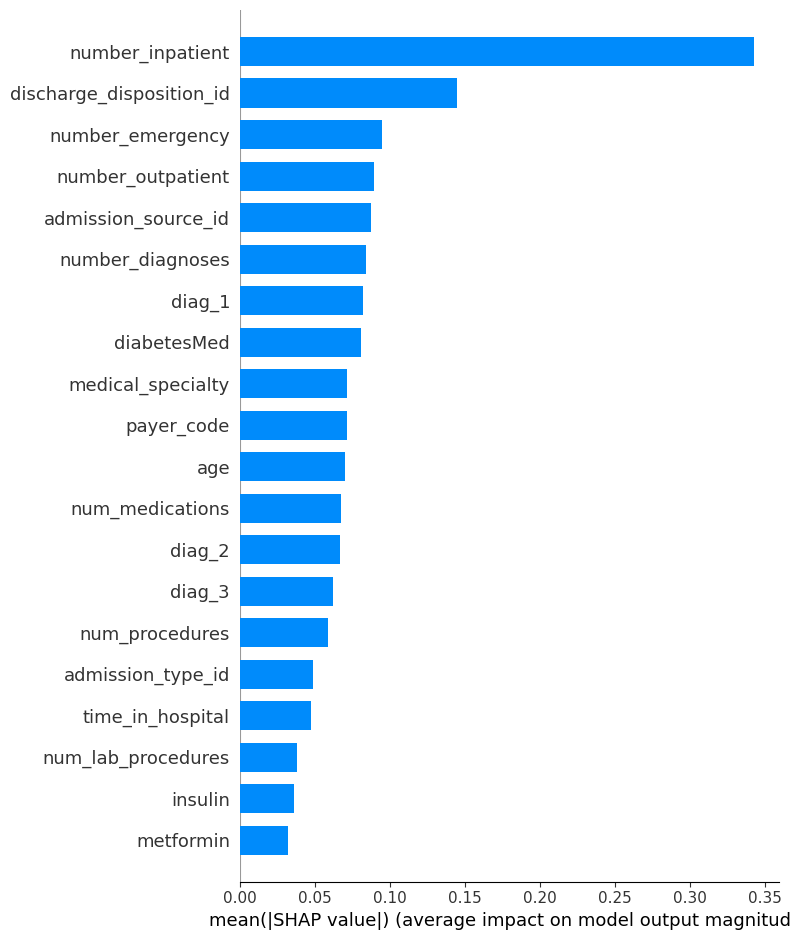

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score, classification_report
import shap
import matplotlib.pyplot as plt

# Step 1: Load the complete dataset
df = pd.read_csv('/content/diabetic_data.csv')

# Step 2: Drop the columns we don't need
df.drop(columns=['encounter_id', 'patient_nbr'], inplace=True)

# Step 3: Get all remaining columns for encoding, except 'readmitted' (the target variable)
columns_to_check = df.columns.tolist()  # List all columns
columns_to_check.remove('readmitted')  # Remove target variable

# Dictionary to store label mappings for each column
label_mappings = {}

# Step 4: Apply Label Encoding and create mappings for all features
for column in columns_to_check:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_mappings[column] = dict(zip(le.classes_, le.transform(le.classes_)))

# Step 5: Encode `readmitted` to binary: 0 for 'NO', 1 for '<30' and '>30'
df['readmitted'] = df['readmitted'].apply(lambda x: 0 if x == 'NO' else 1)
label_mappings['readmitted'] = {'NO': 0, '<30 or >30': 1}

# Step 6: Prepare the data for training
X = df.drop(columns=['readmitted'])
y = df['readmitted']

# Step 7: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Train the CatBoost model
model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, verbose=0)
model.fit(X_train, y_train)

# Step 9: Predictions and Evaluation
y_pred = model.predict(X_test)

# Calculate accuracy and print classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Output results
print("Encoded Dataset:")
print(df.head())
print("\nLabel Mappings:")
print(label_mappings)
print(f'\nAccuracy: {accuracy}')
print('Classification Report:')
print(report)

# Step 10: Plot Feature Importances using CatBoost
plt.figure(figsize=(12, 8))
importances = model.get_feature_importance()
feature_names = X.columns
sorted_idx = importances.argsort()
plt.barh(feature_names[sorted_idx], importances[sorted_idx])
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.show()

# Step 11: Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Step 12: Plot SHAP summary
shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type='bar')


xgboost

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:00:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Encoded Dataset:
   race  gender  age  weight  admission_type_id  discharge_disposition_id  \
0     3       0    0       1                  5                        23   
1     3       0    1       1                  0                         0   
2     1       0    2       1                  0                         0   
3     3       1    3       1                  0                         0   
4     3       1    4       1                  0                         0   

   admission_source_id  time_in_hospital  payer_code  medical_specialty  ...  \
0                    0                 0           0                 38  ...   
1                    6                 2           0                  0  ...   
2                    6                 1           0                  0  ...   
3                    6                 1           0                  0  ...   
4                    6                 0           0                  0  ...   

   citoglipton  insulin  glyburide-metf

<Figure size 1200x800 with 0 Axes>

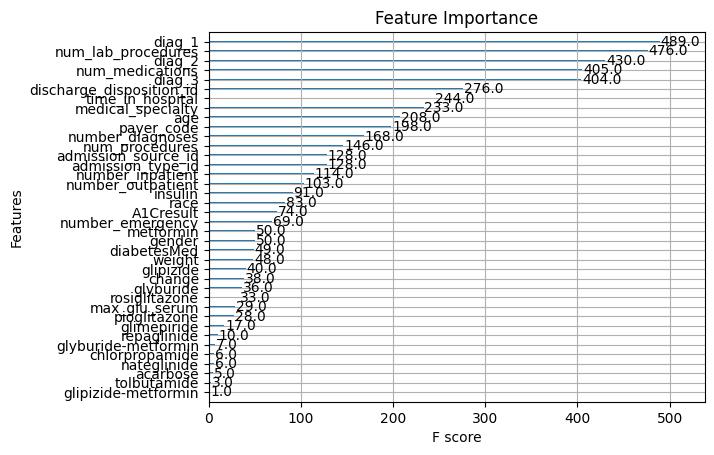

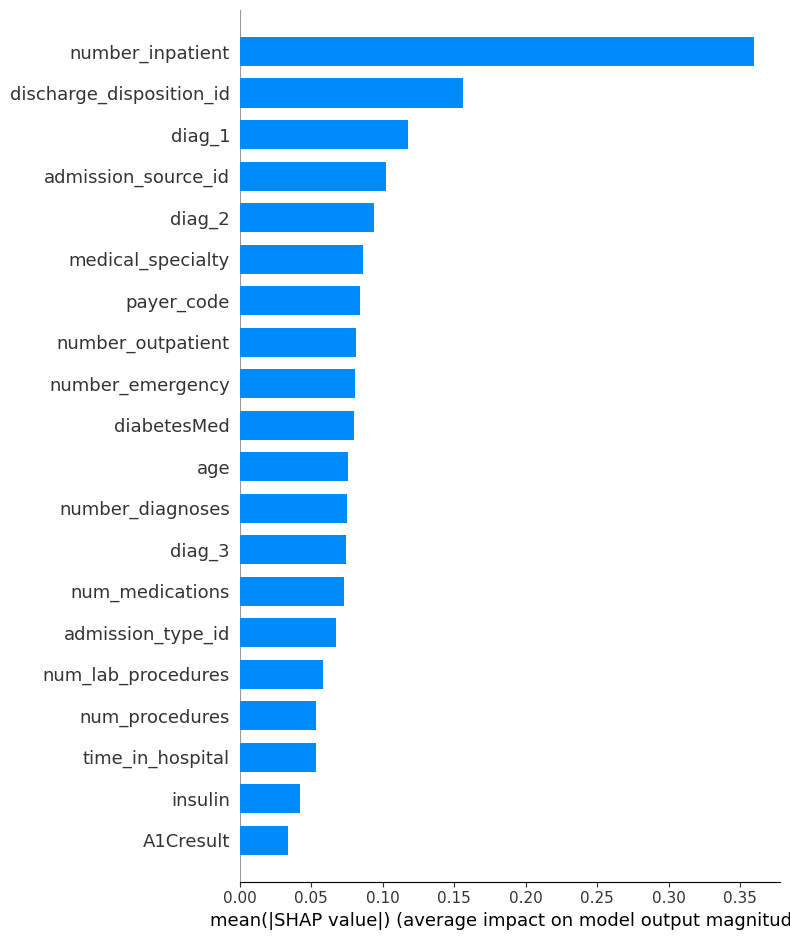

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import xgboost as xgb
import shap

# Step 1: Load the complete dataset
df = pd.read_csv('/content/diabetic_data.csv')

# Step 2: Drop the columns we don't need
df.drop(columns=['encounter_id', 'patient_nbr'], inplace=True)

# Step 3: Get all remaining columns for encoding, except 'readmitted' (the target variable)
columns_to_check = df.columns.tolist()  # List all columns
columns_to_check.remove('readmitted')  # Remove target variable

# Dictionary to store label mappings for each column
label_mappings = {}

# Step 4: Apply Label Encoding and create mappings for all features
for column in columns_to_check:
    # Initialize label encoder
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

    # Store mapping for each column
    label_mappings[column] = dict(zip(le.classes_, le.transform(le.classes_)))

# Step 5: Encode `readmitted` to binary: 0 for 'NO', 1 for '<30' and '>30'
df['readmitted'] = df['readmitted'].apply(lambda x: 0 if x == 'NO' else 1)

# Save mappings for `readmitted` column
label_mappings['readmitted'] = {'NO': 0, '<30 or >30': 1}

# Step 6: Prepare the data for training
# Separate features and target variable
X = df.drop(columns=['readmitted'])
y = df['readmitted']

# Step 7: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Train the XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Step 9: Predictions and Evaluation
y_pred = model.predict(X_test)

# Calculate accuracy and print classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Output results
print("Encoded Dataset:")
print(df.head())
print("\nLabel Mappings:")
print(label_mappings)
print(f'\nAccuracy: {accuracy}')
print('Classification Report:')
print(report)

# Step 10: Plot Feature Importances using XGBoost
plt.figure(figsize=(12, 8))
xgb.plot_importance(model, importance_type='weight')  # You can change to 'gain' or 'cover'
plt.title('Feature Importance')
plt.show()

# Step 11: Calculate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Step 12: Plot SHAP summary
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type='bar')


lightgbm

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Load the complete dataset
df = pd.read_csv('/content/diabetic_data.csv')

# Step 2: Drop the columns we don't need
df.drop(columns=['encounter_id', 'patient_nbr'], inplace=True)

# Step 3: Get all remaining columns for encoding, except 'readmitted' (the target variable)
columns_to_check = df.columns.tolist()  # List all columns
columns_to_check.remove('readmitted')  # Remove target variable

# Dictionary to store label mappings for each column
label_mappings = {}

# Step 4: Apply Label Encoding and create mappings for all features
for column in columns_to_check:
    # Initialize label encoder
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

    # Store mapping for each column
    label_mappings[column] = dict(zip(le.classes_, le.transform(le.classes_)))

# Step 5: Encode `readmitted` to binary: 0 for 'NO', 1 for '<30' and '>30'
df['readmitted'] = df['readmitted'].apply(lambda x: 0 if x == 'NO' else 1)

# Save mappings for `readmitted` column
label_mappings['readmitted'] = {'NO': 0, '<30 or >30': 1}

# Step 6: Prepare the data for training
# Separate features and target variable
X = df.drop(columns=['readmitted'])
y = df['readmitted']

# Step 7: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Train the LightGBM model
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

# Step 9: Predictions and Evaluation
y_pred = lgb_model.predict(X_test)

# Calculate accuracy and print classification report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Output results
print("Encoded Dataset:")
print(df.head())
print("\nLabel Mappings:")
print(label_mappings)
print(f'\nAccuracy: {accuracy}')
print('Classification Report:')
print(report)


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 37500, number of negative: 43912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1200
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.460620 -> initscore=-0.157847
[LightGBM] [Info] Start training from score -0.157847
Encoded Dataset:
   race  gender  age  weight  admission_type_id  discharge_disposition_id  \
0     3       0    0       1                  5                        23   
1     3       0    1       1                  0                         0   
2     1       0    2       1                  0                         0   
3     3       1    3       1                  0                         0   
4     3       1    4       1            